# DeepFalcon Task 3: diffusion models for fast detector simulation



I'll start by importing all the libraries I'm going to use and setting random seeds for reproducible results:

In [1]:
import pyarrow.parquet as pq
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import torch.optim as optim
import math

np.random.seed(42)
torch.manual_seed(42)

And defining some environment variables such as the path to the dataset:

In [2]:
JETS_DIR = '../input/gsoc-2022-eval/Boosted_Jets_Samples'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_WORKERS = 2

# The data

## Exploring the data

We can initially check out some of the data that we have available, loading one of the parquet datasets:

In [3]:
example = pq.ParquetFile(os.path.join(JETS_DIR, 'Boosted_Jets_Sample-0.snappy.parquet'))
num_rows = example.num_row_groups
example.metadata

  created_by: parquet-cpp version 1.5.1-SNAPSHOT
  num_columns: 1
  num_rows: 32000
  num_row_groups: 32000
  format_version: 1.0
  serialized_size: 4164717

In [4]:
example.schema

required group field_id=-1 schema {
  optional group field_id=-1 X_jets (List) {
    repeated group field_id=-1 list {
      optional group field_id=-1 item (List) {
        repeated group field_id=-1 list {
          optional group field_id=-1 item (List) {
            repeated group field_id=-1 list {
              optional double field_id=-1 item;
            }
          }
        }
      }
    }
  }
}

We have only 1 column over here, composed of a list of lists. The task asks us to perform regression though, which would mean we need a target...

Let's check the data out a bit better by using the same data loading pipeline designed by [Ali Hariri on last year's GSoC](https://github.com/ML4SCI/DeepFalcon/tree/main/GNN_for_Fast_Detector_Simulation_Ali_Hariri).

In [5]:
example_row = example.read_row_group(0)
example_dict = example_row.to_pydict()
example_dict.keys()

dict_keys(['X_jets'])

Indeed we only have one column. Exploring the dataset we can see that the elements in this one column are 3x125x125 images:

(3, 125, 125)


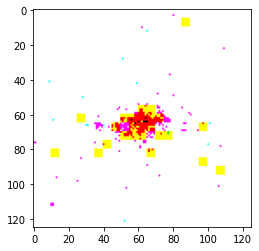

In [6]:
example_data = np.float32(example_dict['X_jets'][0])
print(example_data.shape)
plt.imshow(np.where(example_data.transpose(1,2,0), 0, 255))

Visualization is important in this task, so I'm going to be changing black pixels to white pixels just to make it easier for us to see the changes in the data when we plot it.

Based on last year's GSoC code, [Graph Generative Models for Fast Detector Simulations in Particle Physics paper](https://ml4physicalsciences.github.io/2020/files/NeurIPS_ML4PS_2020_138.pdf) and [End-to-End Physics Event Classification with CMS Open Data](https://arxiv.org/abs/1807.11916), we have that each channel of the image represent a different detector stage:

0. Tracker: constructed as a 2D histogram of the track reconstructed position at perigee in ECAL or HCAL geometry.
1. ECAL: reconstructed hit energies and ECAL crystal coordinates.
2. HCAL: reconstructed hit energies versus HCAL tower coordinates.

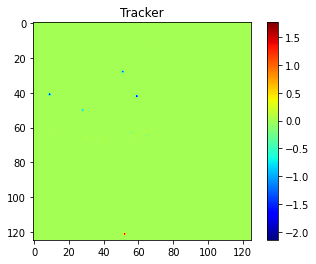

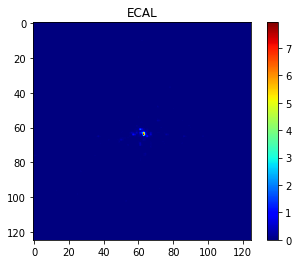

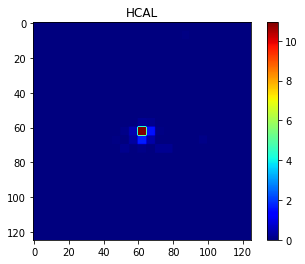

In [7]:
plt.imshow(example_data[0], cmap='jet')
plt.title('Tracker')
plt.colorbar()
plt.show()

plt.imshow(example_data[1], cmap='jet')
plt.title('ECAL')
plt.colorbar()
plt.show()

plt.imshow(example_data[2], cmap='jet')
plt.title('HCAL')
plt.colorbar()
plt.show()

## Dataset and dataloaders

It is also helpful to create custom PyTorch dataloaders in order to load the data more efficiently during training, without the need of loading it all at once on memory (which is not computationally feasible with my resources).

After trying lots of different methods with PyArrow and Dask to read partitioned parquet files efficiently, I wasn't able to come up with a clean way of doing so. Thus I made a hacky method that opens the next file if we've reached the end of the current file:

In [8]:
class JetDataset(Dataset):
    def __init__(self, parquet_files, transform=None, data_col=['X_jets']):
        self.parquets = []
        
        # open each parquet file and count the number of rows
        cumrows = 0
        for f in parquet_files:
            parquet = pq.ParquetFile(f)
            rows = parquet.num_row_groups
            cumrows += rows
            self.parquets.append((parquet, rows, cumrows))
            
        self.transform = transform
        self.data_col = data_col
        
    def __len__(self):
        return sum([i[1] for i in self.parquets])
    
    def __getitem__(self, idx):
        # check in which parquet file the `idx` is in and use that file to load data
        for parquet, rows, cumrows in self.parquets:
            if idx < cumrows:
                break
            else:
                continue
                
        # read data
        idx = idx - (cumrows - rows)
        row = parquet.read_row_group(idx, columns=self.data_col).to_pydict()
        data = np.float32(row['X_jets'][0])
        
        # zero suppression
        data[data < 1.e-3] = 0.
        
        # apply transforms to the data (we're already turning the data to a PyTorch tensor)
        if self.transform:
            data = self.transform(torch.from_numpy(data))
            
        return data

## Splitting train/val/test

We have a HUGE dataset and, as can be seen in my answer to the common task 1 (jet Pt regression), using the whole dataset takes a long time to train. While using Kaggle I gotta be wary of the training time due to notebook runtime restritions, which means that, if I were to use the entire dataset, I'd need to train for fewer epochs. This causes the model to have a subpar performance.

As such, in this task I'm going to be using just a part of the dataset. While the model will have less data to be trained on, at least we'll be able to train it for longer!

I'm only going to be using data augmentation in the dataset, since I believe more information regarding the origins of the data would be needed to apply other pre-processing or data augmentation techniques. Due to memory constraints I'll be downsizing the images.

In [9]:
parquet_files = [os.path.join(JETS_DIR, 'Boosted_Jets_Sample-0.snappy.parquet')]

aug = transforms.Compose([transforms.Resize(64),
                          transforms.RandomHorizontalFlip(),
                          transforms.RandomVerticalFlip()])

train_dataset = JetDataset(parquet_files, aug)
val_dataset = JetDataset(parquet_files)
test_dataset = JetDataset(parquet_files)

In [10]:
len(train_dataset) # == len(val_dataset) == len(test_dataset)

32000

We went from 160000 images to 32000... quite the difference!

Since we'lll be using less data on this task, we're going to use a 80/10/10 split:

In [11]:
train_size = 0.8

num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(train_size * num_train))
split2 = int(np.floor((train_size+(1-train_size)/2) * num_train))
np.random.shuffle(indices)
train_idx, valid_idx, test_idx = indices[:split], indices[split:split2], indices[split2:]

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

train_data = Subset(train_dataset, indices=train_idx)
val_data = Subset(val_dataset, indices=valid_idx)
test_data = Subset(test_dataset, indices=test_idx)

In [12]:
print('train dataset size:', len(train_data), 'percentage of train dataset:', len(train_data) / len(train_dataset))
print('val dataset size:', len(val_data), 'percentage of val dataset:', len(val_data) / len(train_dataset))
print('test dataset size:', len(test_data), 'percentage of test dataset:', len(test_data) / len(train_dataset))

train dataset size: 25600 percentage of train dataset: 0.8
val dataset size: 3200 percentage of val dataset: 0.1
test dataset size: 3200 percentage of test dataset: 0.1


We can now create the dataloaders that will be used for training, validation and testing:

In [13]:
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
val_dataloader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

# Scaling the data

From what I've gathered, it is not necessary to rescale the data for diffusion models, but I'm going to do it so that we can compare these results with the ones we got from the VAE on task 2. Since each channel in our data is from a different detector, I'm going to be considering the minimum and maximum values of each channel (tracker, ECAL, HCAL) separately.

In [14]:
"""
mins = {'tracker': [], 'ecal': [], 'hcal': []}
maxs = {'tracker': [], 'ecal': [], 'hcal': []}

for data in train_dataloader:
    tracker = data[:, 0]
    ecal = data[:, 1]
    hcal = data[:, 2]
    
    mins['tracker'].append(tracker.min())
    mins['ecal'].append(ecal.min())
    mins['hcal'].append(hcal.min())
    
    maxs['tracker'].append(tracker.max())
    maxs['ecal'].append(ecal.max())
    maxs['hcal'].append(hcal.max())

# (min, max)
tracker_scaler = (min(mins['tracker']), max(maxs['tracker']))
ecal_scaler = (min(mins['ecal']), max(maxs['ecal']))
hcal_scaler = (min(mins['hcal']), max(maxs['hcal']))
"""

# this code takes a while to run, so i'm hard coding the results
tracker_scaler = (0.0, 2.4999)
ecal_scaler = (0.0, 153.6213)
hcal_scaler = (0.0, 30.9880)

# organizing by channel
data_scale = {0: tracker_scaler, 1: ecal_scaler, 2: hcal_scaler}
data_scale

{0: (0.0, 2.4999), 1: (0.0, 153.6213), 2: (0.0, 30.988)}

This allows us to rescale the data into one of these ranges using:

$x_{std} = \frac{x - x_{min}}{x_{max} - x_{min}} \rightarrow x_{scaled} = x_{std} \cdot (n_{max} - n_{min}) + n_{min}$

Where $n_{min}$ represents the new minimum value and $n_{max}$ represents the new maximum value. In our case, we'll set it to $n_{min} = 0$ and $n_{max} = 1$.

In [15]:
def min_max_scaler(data, data_scale, new_scale=(0,1)):
    new_min, new_max = new_scale
    data = data.clone()
    
    # iterate through each channel, scaling according to its (min, max)
    for channel in data_scale:
        data_min, data_max = data_scale[channel]

        channel_data = data[:, channel]

        data_std = (channel_data - data_min) / (data_max - data_min)
        data_scaled = data_std * (new_max - new_min) + new_min

        data[:, channel] = data_scaled
    
    return data

I'm going to be using it during the training and evaluation loop whenever we're load in new data. This could be made into a transform to be used when creating our dataset but due to the way I'm currently splitting the data (after creating a dataset) I'd need to colect the minimum and maximum value statistics on all data. This would cause a ton of *data leakage*, since the values we get would also be computed using the val and test data.

# Creating the diffusion model

Diffusion models are a kind of generative model that work by defining a Markov chain of diffusion steps that gradually add random noise (usually Gaussian) to the input. The model then learns to reverse the diffusion process in order to generate new data from noise.

I'm going to be basing my model off of the [Denoising Diffusion Probabilistic Models paper](https://arxiv.org/abs/2006.11239) and the excellent [PyTorch implementation of the paper available at labml.ai](https://nn.labml.ai/diffusion/ddpm/). As such, I'm gonna be employing a U-Net backbone with self-attention.

## U-Net with attention

This attention-based U-net model is what we'll be using to predict the noise in our diffusion model. The U-Net architecture was created and is commonly used in image segmentation tasks, where we want to predict the class of each pixel in an image. This is done by gradually lowering the resolution of the image and then increasing it again, with pass-through connections at each resolution scale.

I'm also going to be making the VAE receive as input an 1 channel image. This is because we want to reconstruct Tracker, ECAL and HCAL images, and each are a channel in our data. So this way we can basically consider that each of the channels is a different class

### Helper classes

We'll first define some helper classes: a Swish activation function, a "time" embedding (for sinusoidal positional embeddings, as present in the transformer architecture) a residual block (similar to the ones used in ResNet architectures) and an attention block (similar to transformer's multi-head attention):

In [16]:
class Swish(nn.Module):
    def forward(self, x):
        return x * torch.sigmoid(x)
    
class TimeEmbedding(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        self.n_channels = n_channels # number of channels in embedding
        
        self.lin1 = nn.Linear(self.n_channels // 4, self.n_channels)
        self.act = Swish()
        self.lin2 = nn.Linear(self.n_channels, self.n_channels)

    def forward(self, t: torch.Tensor):
        half_dim = self.n_channels // 8
        emb = math.log(10_000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=t.device) * -emb)
        emb = t[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=1)

        emb = self.act(self.lin1(emb))
        emb = self.lin2(emb)

        return emb
    
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, n_groups=32):
        super().__init__()
        self.norm1 = nn.GroupNorm(n_groups, in_channels)
        self.act1 = Swish()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        self.norm2 = nn.GroupNorm(n_groups, out_channels)
        self.act2 = Swish()
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1))

        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        self.time_emb = nn.Linear(time_channels, out_channels)

    def forward(self, x, t):
        h = self.conv1(self.act1(self.norm1(x)))
        h += self.time_emb(t)[:, :, None, None]
        h = self.conv2(self.act2(self.norm2(h)))

        return h + self.shortcut(x)

class AttentionBlock(nn.Module):
    def __init__(self, n_channels, n_heads=1, d_k=None, n_groups=32):
        super().__init__()

        if d_k is None:
            d_k = n_channels
            
        self.norm = nn.GroupNorm(n_groups, n_channels)
        self.projection = nn.Linear(n_channels, n_heads * d_k * 3)
        self.output = nn.Linear(n_heads * d_k, n_channels)
        self.scale = d_k ** -0.5
        
        self.n_heads = n_heads
        self.d_k = d_k

    def forward(self, x, t=None):
        _ = t
        
        batch_size, n_channels, height, width = x.shape
        x = x.view(batch_size, n_channels, -1).permute(0, 2, 1)
        qkv = self.projection(x).view(batch_size, -1, self.n_heads, 3 * self.d_k)
        q, k, v = torch.chunk(qkv, 3, dim=-1)
        attn = torch.einsum('bihd,bjhd->bijh', q, k) * self.scale
        attn = attn.softmax(dim=1)
        res = torch.einsum('bijh,bjhd->bihd', attn, v)
        res = res.view(batch_size, -1, self.n_heads * self.d_k)
        res = self.output(res)

        res += x
        res = res.permute(0, 2, 1).view(batch_size, n_channels, height, width)

        return res

### U-Net modules

Now we'll be creating some "U-Net specific" modules related to the changes in resolution:

In [17]:
class DownBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, has_attn):
        super().__init__()
        
        self.res = ResidualBlock(in_channels, out_channels, time_channels)
        
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class UpBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_channels, has_attn):
        super().__init__()
        
        self.res = ResidualBlock(in_channels + out_channels, out_channels, time_channels)
        
        if has_attn:
            self.attn = AttentionBlock(out_channels)
        else:
            self.attn = nn.Identity()

    def forward(self, x, t):
        x = self.res(x, t)
        x = self.attn(x)
        return x


class MiddleBlock(nn.Module):
    def __init__(self, n_channels, time_channels):
        super().__init__()
        
        self.res1 = ResidualBlock(n_channels, n_channels, time_channels)
        self.attn = AttentionBlock(n_channels)
        self.res2 = ResidualBlock(n_channels, n_channels, time_channels)

    def forward(self, x, t):
        x = self.res1(x, t)
        x = self.attn(x)
        x = self.res2(x, t)
        return x


class Upsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        self.conv = nn.ConvTranspose2d(n_channels, n_channels, (4, 4), (2, 2), (1, 1))

    def forward(self, x, t):
        _ = t
        return self.conv(x)


class Downsample(nn.Module):
    def __init__(self, n_channels):
        super().__init__()
        
        self.conv = nn.Conv2d(n_channels, n_channels, (3, 3), (2, 2), (1, 1))

    def forward(self, x, t):
        _ = t
        return self.conv(x)

### U-Net

Finally, here's the U-Net implementation. We have it so that here:

- `image_channels` is the number of channels in the image.
- `n_channels` is number of channels in the initial feature map.
- `ch_mults` is the list of channels at each resolution. The number of channels is `ch_mults[i] * n_channels`
- `is_attn` is a list of booleans that indicate whether to use attention or not at each resolution.
- `n_blocks` is the number of `UpDownBlocks` at each resolution.


In [18]:
class UNet(nn.Module):
    def __init__(self, image_channels=1, n_channels=64, ch_mults=(1, 2, 2, 4),
                 is_attn=(False, False, True, True), n_blocks=2):
        super().__init__()

        # number of resolutions
        n_resolutions = len(ch_mults)

        # project image into feature map
        self.image_proj = nn.Conv2d(image_channels, n_channels, kernel_size=(3, 3), padding=(1, 1))

        # time embedding layer
        self.time_emb = TimeEmbedding(n_channels * 4)

        # FIRST PART OF U-NET: decreasing resolution
        down = []
        out_channels = in_channels = n_channels
        
        for i in range(n_resolutions):
            # output channels at this resolution
            out_channels = in_channels * ch_mults[i]
            
            for _ in range(n_blocks):
                down.append(DownBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                in_channels = out_channels
            
            # downscale at all resolutions except the last
            if i < n_resolutions - 1:
                down.append(Downsample(in_channels))

        # combine the set of modules
        self.down = nn.ModuleList(down)

        # middle block
        self.middle = MiddleBlock(out_channels, n_channels * 4, )

        # SECOND PART OF U-NET: increasing resolution
        up = []
        in_channels = out_channels
        
        for i in reversed(range(n_resolutions)):
            out_channels = in_channels
            
            for _ in range(n_blocks):
                up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
                
            # reduce the number of channels
            out_channels = in_channels // ch_mults[i]
            up.append(UpBlock(in_channels, out_channels, n_channels * 4, is_attn[i]))
            in_channels = out_channels
            
            # upscale at all resolutions except last
            if i > 0:
                up.append(Upsample(in_channels))

        self.up = nn.ModuleList(up)

        # final normalization and convolution layer
        self.norm = nn.GroupNorm(8, n_channels)
        self.act = Swish()
        self.final = nn.Conv2d(in_channels, image_channels, kernel_size=(3, 3), padding=(1, 1))

    def forward(self, x, t):
        # time embeddings
        t = self.time_emb(t)

        # image projection
        x = self.image_proj(x)

        # `h` stores outputs at each resolution for skip connection
        h = [x]
        
        # first half of U-Net
        for m in self.down:
            x = m(x, t)
            h.append(x)

        # middle
        x = self.middle(x, t)

        # second half of U-Net
        for m in self.up:
            if isinstance(m, Upsample):
                x = m(x, t)
                
            else:
                # get skip connection from first half of U-Net and concatenate
                s = h.pop()
                x = torch.cat((x, s), dim=1)
                x = m(x, t)

        # final normalization and convolution
        return self.final(self.act(self.norm(x)))

## Diffusion model

Now that we have the model the architecture that will reconstruct our images, we can begin to implement the diffusion model that'll be used to reconstruct the events. We'll need to implement:

1. **The forward process**: it adds noise to the input data $x_0 \sim q(x_0)$ in $T$ steps. This produces a sequence of noisy samples $x_1, \cdots, x_T$, where the step sizes are controlled by $\{\beta_t \in (0,1)\}_{t=1}^t$, such that:

    $$q(x_t | x_{t-1}) = \mathcal{N}\big(x_t; \sqrt{1-  \beta_t} x_{t-1}, \beta_t \mathbf{I}\big); \; q(x_{1:T} | x_0) = \prod_{t = 1}^{T} q(x_t | x_{t-1})$$
    
    As $t$ increases, $x_0$ gradually loses its features, becoming equivalent to an isotropic Gaussian distribution ad infinitum.

    We can sample $x_t$ at an arbitrary step $t$, where $\alpha_t = 1 - \beta_t$ and $\bar\alpha_t = \prod_{i=1}^T \alpha_i$ with 
    
    $$q(x_t|x_0) = \mathcal{N} \Big(x_t; \sqrt{\bar\alpha_t} x_0, (1-\bar\alpha_t) \mathbf{I} \Big)$$
    
2. **The backward process**: it removes noise. If we could reverse the process of adding noise and sample directly $q(x_{t-1} | x_t)$ we would be able to recreate the true data from a Gaussian noise input. However, since we cannot estimate this conditional probability, we need to learn a model $p_\theta$ that approximates $q(x_{t-1} | x_t)$ starting from $p(x_T) = \mathcal{N}(x_T; \mathbf{0}, \mathbf{I})$, for $T$ steps such that:

    $$p_\theta(x_{t-1} | x_t) = \mathcal{N}\big(x_{t-1}; \mu_\theta x_t, t), \Sigma_\theta (x_t, t) \big) ; \; p_\theta (x_{0:T}) = p_\theta (x_T) \prod_{t = 1}^{T} p_\theta (x_{t-1} | x_t)$$
    
    Where $\theta$ are the parameters we learn.
    
3. **The loss**: in order to do that we use a simplified objective based on Jensen's inequality:

    $$L_t(\theta) = \mathbb{E}_{t,x_0, \epsilon} \Bigg[ \bigg\Vert
\epsilon - \epsilon_\theta (\sqrt{\bar\alpha_t} x_0 + \sqrt{1-\bar\alpha_t}\epsilon, t)
\bigg\Vert^2 \Bigg]$$
    
    

In [19]:
def gather(consts, t):
    c = consts.gather(-1, t)
    return c.reshape(-1, 1, 1, 1)


class Diffusion:
    def __init__(self, model, n_steps, device):
        super().__init__()
        
        self.model = model

        # make betas linearly
        self.beta = torch.linspace(0.0001, 0.02, n_steps).to(device)

        self.alpha = 1. - self.beta
        self.alpha_bar = torch.cumprod(self.alpha, dim=0)
        self.n_steps = n_steps # T
        self.sigma_squared = self.beta

    def q_xt_x0(self, x0, t):
        """
        get q(x_t|x_0) distribution
        """
        
        mean = gather(self.alpha_bar, t) ** 0.5 * x0
        var = 1 - gather(self.alpha_bar, t)
        return mean, var

    def q_sample(self, x0, t, eps=None):
        """
        sample from q(x_t|x_0)
        """

        if eps is None:
            eps = torch.randn_like(x0)

        mean, var = self.q_xt_x0(x0, t)
        return mean + (var ** 0.5) * eps

    def p_sample(self, xt, t):
        """
        sample from p_\theta(x_{t-1}|x_t)
        """

        eps_theta = self.model(xt, t)
        alpha_bar = gather(self.alpha_bar, t)
        alpha = gather(self.alpha, t)
        
        eps_coef = (1 - alpha) / (1 - alpha_bar) ** .5
        mean = 1 / (alpha ** 0.5) * (xt - eps_coef * eps_theta)
        var = gather(self.sigma_squared, t)

        eps = torch.randn(xt.shape, device=xt.device)
        
        return mean + (var ** .5) * eps

    def loss(self, x0, noise=None):
        batch_size = x0.shape[0]
        # get random t for each sample in the batch
        t = torch.randint(0, self.n_steps, (batch_size,), device=x0.device, dtype=torch.long)

        if noise is None:
            noise = torch.randn_like(x0)

        # sample x_t for q(x_t|x_0)
        xt = self.q_sample(x0, t, eps=noise)
        eps_theta = self.model(xt, t)

        return F.mse_loss(noise, eps_theta)

## Training loop

I'll first define a function that enables us to see how the diffusion model learns to reconstruct our data as it is being trained (`vmin` and `vmax` are hard-coded based on the values that I found to output good visualizations; notice that the data received by the function is already scaled between 0 and 1):

In [20]:
def display_images(input_image, output_image, display=1):
    titles = ['Tracker', 'ECAL', 'HCAL']
    
    for d in range(display):
        # plot input images
        input_image_numpy = input_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))
        plt.suptitle('Original images // Reconstructed images', fontsize=20)

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(input_image_numpy[i+4*d][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i])
            plt.axis(False)

        plt.show()
                
        # plot output images
        output_image_numpy = output_image.detach().cpu().numpy()
        plt.figure(figsize=(18,6))

        # plot 4 images
        for i in range(len(titles)):
            plt.subplot(1, 3, i+1)
            
            plt.imshow(output_image_numpy[i+4*d][i], cmap='jet', vmin=0, vmax=0.01)
            plt.colorbar()
            plt.title(titles[i] + '?')
            plt.axis(False)
            
        plt.show()

Now all we need is to define how our model will be trained. For demonstration purposes I'm going to make the hyperparameters fixed. I'll also be using the validation dataset for early stopping if the validation loss stops decreasing.

In [21]:
def sample(diffusion, dataloader, data_scale, display=0):
    # set network to evaluation mode
    diffusion.model.eval()
    
    running_loss = 0.0
    reconstructed = []
    
    with torch.no_grad():
        for data in dataloader:
            outputs_list = [] # used for displaying reconstructed images

            # we'll be iterating over each channel in order to update the VAE weights
            # for each Tracker, ECAL, HCAL image inside `data`
            for channel in range(3):
                #x = torch.randn([n_samples, image_channels, image_size, image_size], device=DEVICE)
                x = torch.randn([1, 1, 64, 64], device=DEVICE)

                # remove noise for T steps
                for t_ in range(diffusion.n_steps):
                    t = diffusion.n_steps - t_ - 1
                    # sample from p_\theta (x_{t-1}|x_t)
                    x = diffusion.p_sample(x, x.new_full((1,), t, dtype=torch.long))

                running_loss += diffusion.loss(x).item()
            
                outputs_list.append(x)
            
            # concatenate reconstructed images (Tracker, ECAL, HCAL)
            outputs_list = torch.cat(outputs_list, dim=1)
            reconstructed.append(outputs_list)
            
        # get loss over whole dataset
        loss = running_loss / len(dataloader)
        
        # display images
        if display:
            reconstructed = torch.cat(reconstructed, dim=0)
            display_images(data, reconstructed, display)
            
    return loss
    

def train(diffusion, train_dataloader, val_dataloader, data_scale, epochs):
    # hyperparameters and optimizer
    lr = 1e-3
    
    optimizer = optim.Adam(diffusion.model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    
    # early stopping variables
    best_loss = np.inf # ideal loss == 0
    patience = 5 # stops training if loss doesn't improve in 5 epochs
    bad_epochs = 0
    
    # metrics
    history = {'train_loss': [], 'val_loss': []}
    
    # train
    for epoch in range(epochs):
        # set network to training mode
        diffusion.model.train()

        running_loss = 0.0

        for data in train_dataloader:
            data = data.to(DEVICE)
            data = min_max_scaler(data, data_scale)

            # we'll be iterating over each channel in order to update the weights
            # for each Tracker, ECAL, HCAL image inside `data`
            for channel in data_scale:
                # unsqueeze to generate 1 channel axis
                data_channel = data[:, channel].unsqueeze(1)
                
                # zero gradients
                optimizer.zero_grad()

                # encode/decode ang get loss
                loss = diffusion.loss(data_channel)

                # backpropagate and update weights
                loss.backward()
                optimizer.step()

                # metrics
                running_loss += loss.item()

        # get metrics
        epoch_loss = running_loss / len(train_dataloader)
        history['train_loss'].append(epoch_loss)
        
        # lr scheduler
        scheduler.step()
        
        # evaluate on validation data
        val_epoch_loss = sample(diffusion, val_dataloader, data_scale, display=1)
        history['val_loss'].append(val_epoch_loss)

        print('[Epoch {}/{}] loss: {:.6f}; val loss: {:.6f};'.format(epoch+1, epochs, epoch_loss, val_epoch_loss))
        
        # save checkpoint
        if val_epoch_loss < best_loss:
            torch.save({'unet_weights': diffusion.model.state_dict()}, './model_task3.pt')
            best_loss = val_epoch_loss
            bad_epochs = 0
            
        else:
            bad_epochs += 1

        if bad_epochs >= patience:
            print(f"reached {bad_epochs} bad epochs, stopping training with best val loss of {best_loss}!")
            break

    best = torch.load('./model_task2.pt')
    diffusion.model.load_state_dict(best['unet_weights'])

    return diffusion, history

## Training the model

Now we just need to train our diffusion model! I'm training for just 3 epochs because... it takes A LOT of time to train this model. Even while downsizing the images, it requires a lot of computation and after 3 epochs I'm already exceeding the maximum Kaggle runtime. That said, there's probably a lot of bugs and the code isn't at all optimized!

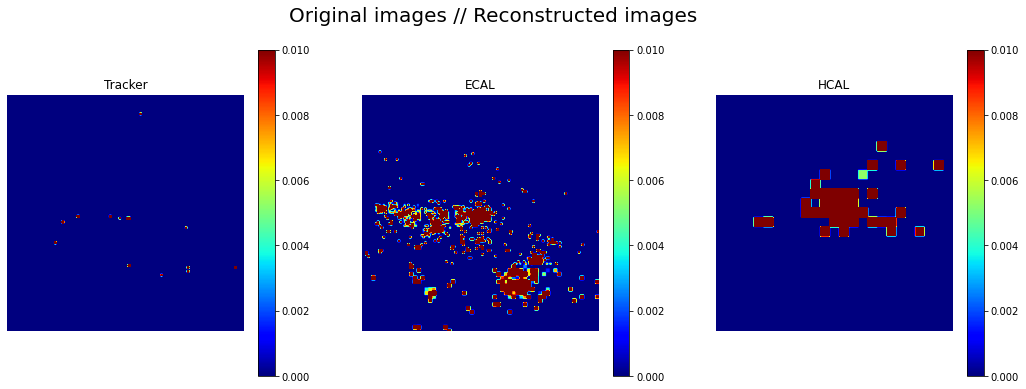

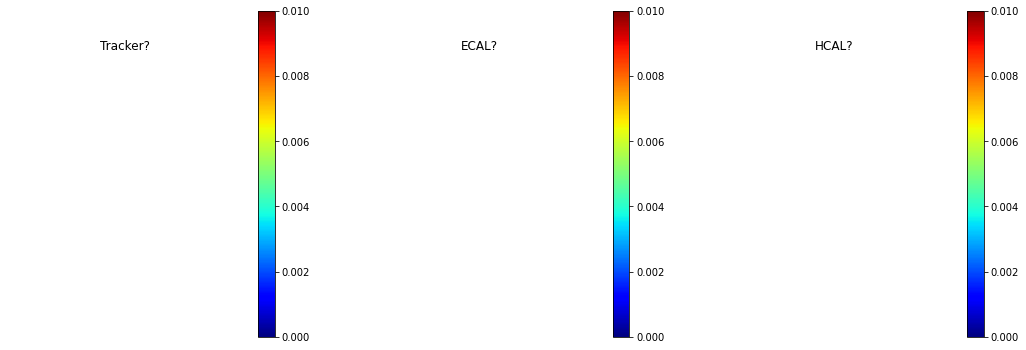

[Epoch 1/3] loss: nan; val loss: nan;


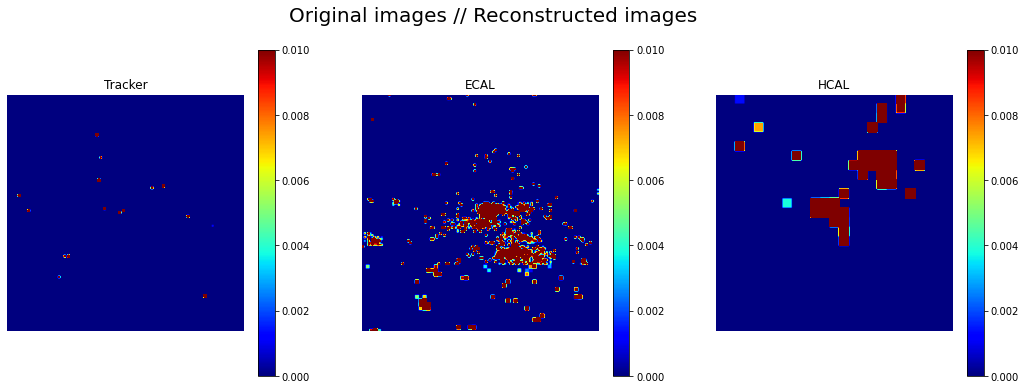

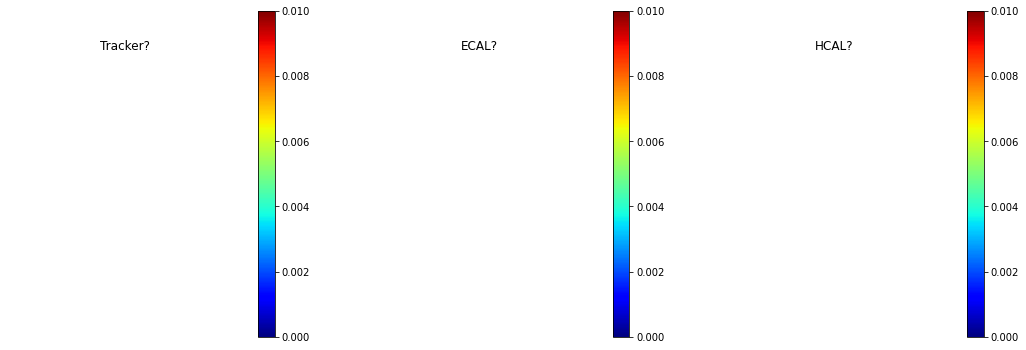

[Epoch 2/3] loss: nan; val loss: nan;


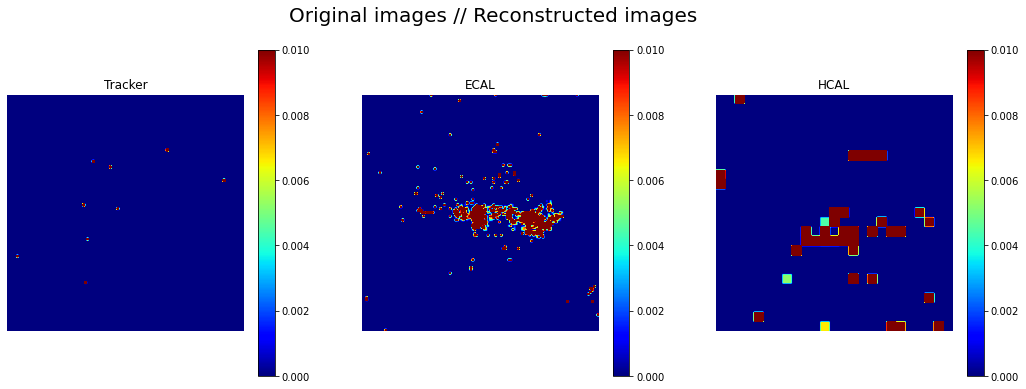

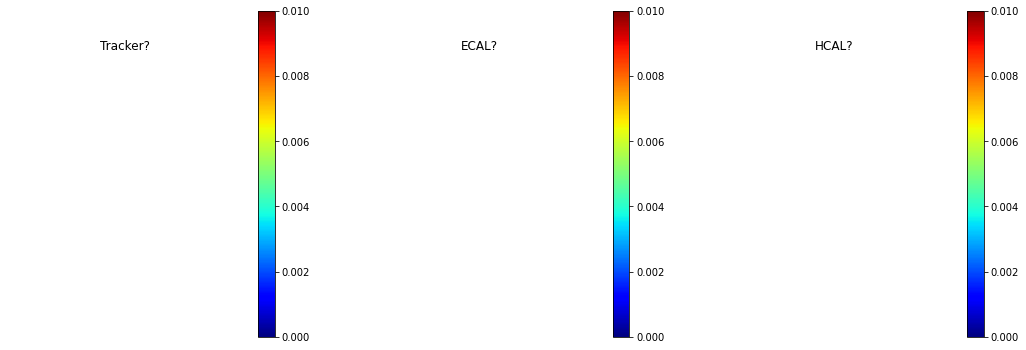

[Epoch 3/3] loss: nan; val loss: nan;


FileNotFoundError: [Errno 2] No such file or directory: './model_task2.pt'

In [22]:
unet = UNet()
unet = unet.to(DEVICE)

diffusion = Diffusion(unet, 1000, DEVICE)

encoder, decoder, history = train(diffusion, train_dataloader, val_dataloader, data_scale, epochs=3)

We can also look at the training metrics in order to see how it evolves over time:

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12,5), dpi=200)

plt.style.use('ggplot')

epochs = len(history['train_loss'])

axs[0].plot(range(1, epochs+1), history['train_loss'])
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].set_title('Train loss')

# it goes to NaN for some reason
#axs[1].plot(range(1, epochs+1), history['val_loss']) 
#axs[1].set_xlabel('Epochs')
#axs[1].set_ylabel('Loss')
#axs[1].set_title('Validation loss')

plt.show()

## Evaluating the model

The loss of the model on the test set and some reconstructions of the test set are given by:

In [ ]:
test_loss = sample(diffusion, test_dataloader, data_scale, display=3)
print('LOSS ON GENERATION:', test_loss)

## Conclusion

Yeaaah... the code is kinda buggy. There's a lot of work that would still be needed to optimize it. But when the loss goes to NaN, it's neveer a good sign. Due to time constraints related to the submission deadline I wasn't able to work with the code more. But if I had more time the first thing I'd do is "cross check" my implementation (and the implementation I'm basing mine off of) with other popular diffusion model implementations. There are quite a lot that seem to be quite thorough with their code and explanation! Notice, for example, that this implementation doesn't employ an Exponential Moving Average (EMA), while the official paper does.

Other than that, there's probably some error hiding in some of the functions and classes that is anihilating the learning of the model. So more work would definitely need to be done, but, fortunately, there's a lot that can be done to work through this!